<a href="https://colab.research.google.com/github/N0elle-08/MScDataScience/blob/main/AttentionNLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem - Sequence-to-Sequence Models for Neural Machine Translation
The machine translation problem has thrust us towards inventing the “Attention Mechanism”. Machine translation is the automatic conversion from one language to another. The conversion has to happen using a computer program, where the program has to have the intelligence to convert the text from one language to the other. When a neural network performs this job, it's called “Neural Machine Translation".

A sequence-to-sequence model consists of two essential components: an encoder and a decoder. The encoder's primary function is to generate a context vector, which serves as an encoded representation of the input sequence. Subsequently, the decoder utilizes this context vector to initiate the generation of the desired output sequence.

The encoder-decoder sequence-to-sequence model is akin to the traditional translation process. It encodes the source language into a fixed-length representation and then decodes it into the target language. However, this model faces challenges with long sequences, potentially losing vital information.

The model typically uses the encoder's final state as the context vector, neglecting intermediate states. To address these limitations, the attention mechanism is introduced, enabling the model to dynamically focus on relevant positions in the input and enhance overall performance.

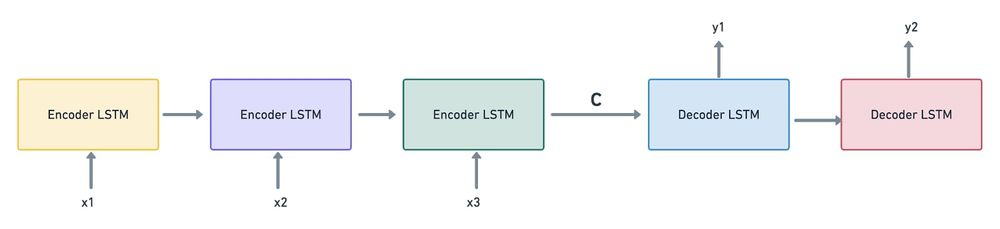

#Attention Mechanism
In the realm of neural machine translation, "Attention" addresses the challenges in training a sequence-to-sequence model. With attention, the model no longer compresses the encoded output into a single context vector. Instead, it encodes the input as a sequence of vectors and selectively focuses on specific vectors based on the decoder's hidden states. In essence, attention ensures the model "attends" to what's essential while retaining other crucial information.

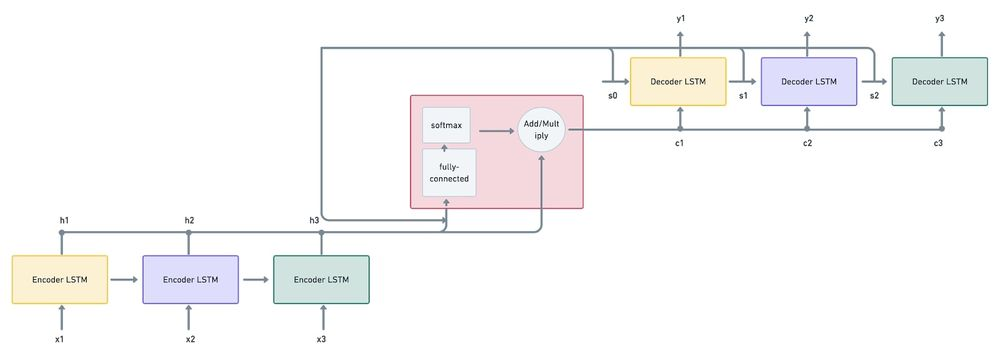

The machine translation problem is solved using the attention mechanism through the following steps:

1. The input sequence, e.g., x1, x2, x3, is provided to the encoder LSTM, generating vectors h1, h2, h3. These vectors serve as inputs for the attention mechanism.

2. The decoder initiates with the first state vector, s0, which is also input into the attention mechanism, along with h1, h2, h3.

3. The attention mechanism, represented in the red box, processes these inputs through a fully-connected network and softmax activation, producing "attention weights."

4. A context vector, c1, is computed as the weighted sum of the encoder's output vectors, scaled according to the attention weights.

5. The decoder uses the context vector and state vectors to generate the output vector y1.

6. The decoder's subsequent state vector, s1, is also fed into the attention mechanism alongside the encoder's outputs, yielding a new context vector, c2.

7. This process repeats until all decoder outputs, e.g., y1, y2, y3, are produced.

## Categories of Attention Mechanisms
**Self-attention mechanism**, also known as intra-attention, is a mechanism that allows a neural network to weigh the importance of different elements within the same input sequence when making predictions, enabling it to focus on relevant elements while processing the sequence. Model interacts with itself.

**Soft Attention Mechanism** places attention weights over all input parts, using a weighted average mechanism that emphasizes relevant features and learns continuously.

**Hard Attention mechanism** focuses solely on specific input areas and requires sampling and Monte Carlo averaging to estimate gradients for other states during backpropagation.

#Import Dataset

In [ ]:
import pandas as pd
import regex as re

In [ ]:
# Here we get the fra-eng dataset
! wget http://www.manythings.org/anki/fra-eng.zip

# Here we are unzipping the zip
! unzip fra-eng.zip -d fra-eng

--2023-11-10 14:19:45--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757635 (7.4M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.40M  47.5MB/s    in 0.2s    

2023-11-10 14:19:46 (47.5 MB/s) - ‘fra-eng.zip’ saved [7757635/7757635]

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


In [ ]:
# Get the txt file which has English -> French translation
path_to_file = "/content/fra-eng/fra.txt"

# Dataset Preprocessing
Normalize Unicode characters and clean sequence tokens using regular expressions.

This cleaning process includes:
* Removing unwanted spaces.
* Adding a space between words and their punctuation.
* Replacing unwanted characters with spaces.
* Appending "<start>" and "<end>" tokens to mark sequence boundaries.
* unicode_to_ascii() and preprocess_sentence(), handle Unicode conversion and sequence preprocessing, respectively.

In [ ]:
import unicodedata

import re

# Convert the unicode sequence to ascii
def unicode_to_ascii(s):

  # Normalize the unicode string and remove the non-spacking mark
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Preprocess the sequence
def preprocess_sentence(w):

  # Clean the sequence
  w = unicode_to_ascii(w.lower().strip())

  # Create a space between word and the punctuation following it
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # Add a start and stop token to detect the start and end of the sequence
  w = '<start> ' + w + ' <end>'
  return w

#Prepare Dataset
Prepare the dataset from the raw data to train the model, by creating word pairs by combining English sequences with their corresponding French sequences.

In [ ]:
import io

# Create the Dataset
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  # Loop through lines (sequences) and extract the English and French sequences. Store them as a word-pair
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t', 2)[:-1]]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [ ]:
en, fra = create_dataset(path_to_file, None)
print(en[-1])
print(fra[-1])

<start> i went drinking with one of my boyfriend s friends , and now he s furious at me . was this friend a guy or a girl ? a guy , obviously . why would i go drinking with his female friends ? yeah , you re right . his name is tom . he s really hot , and i really want to go drinking with him again . <end>
<start> je suis allee boire avec un ami de mon compagnon , et voila qu il est furieux contre moi . etait ce un gars ou une fille ? un gars , bien evidemment . pourquoi irais je boire avec ses amies ? ouais , ca se comprend . il s appelle tom . il est trop canon , et j ai tellement envie d aller prendre un verre avec lui a nouveau . <end>


## Tokenization
In this step, we perform tokenization, which involves creating an internal vocabulary for both English and French. This vocabulary is used to convert words (tokens) in the sequences into corresponding integers. Additionally, we pad the sequences to ensure they all have the same length. Tokenization is a crucial preparation step that simplifies the model training process by ensuring consistent data format and sequence lengths

In [ ]:
import tensorflow as tf

# Convert sequences to tokenizers
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')

  # Convert sequences into internal vocab
  lang_tokenizer.fit_on_texts(lang)

  # Convert internal vocab to numbers
  tensor = lang_tokenizer.texts_to_sequences(lang)

  # Pad the tensors to assign equal length to all the sequences
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
# Load the tokenized dataset by calling the create_dataset() and tokenize() functions.
def load_dataset(path, num_examples=None):

  # Create dataset (targ_lan = English, inp_lang = French)
  targ_lang, inp_lang = create_dataset(path, num_examples)

  # Tokenize the sequences
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Consider 50k examples
num_examples = 50000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80/20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))



40000 40000 10000 10000


In [ ]:
# Show the mapping b/w word index and language tokenizer
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
21 ----> c
5 ----> est
44 ----> tout
26 ----> ce
28 ----> que
4 ----> je
85 ----> fais
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
17 ----> that
11 ----> s
42 ----> all
4 ----> i
22 ----> do
3 ----> .
2 ----> <end>


#Initialize - Model Parameters

In [ ]:
# Essential model parameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Size of input and target batches
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 17]), TensorShape([64, 10]))

#Encoder
The Encoder class is a crucial component of a sequence-to-sequence model responsible for encoding the input data, and it consists of two main methods: __init__() and call().

 *__init__*() method, the class is initialized with various parameters, including vocabulary size, embedding dimension, encoder units, and batch size. Within this method, several layers are defined:

An embedding layer for mapping vocabulary words to dense embeddings.
An LSTM (Long Short-Term Memory) layer that has enc_units units, returns sequences, and states, and uses glorot_uniform as the recurrent initializer.

*call()* method takes two arguments: x, representing the input data, and hidden, which is the initial hidden state for the LSTM.
The input x is passed through the embedding layer to convert words into embedded vectors.These embedded vectors are then fed into the LSTM layer. The method returns two important values: output, which is the output sequence from the encoder, and state, representing the final hidden states of the LSTM.

The initialize_hidden_state() method is used to create the initial hidden state for the LSTM. It initializes two states, state_h and state_c, both filled with zeros.

In [ ]:
import tensorflow as tf

# Encoder class with LSTM
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units

        # Embed the vocab to a dense embedding
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # LSTM Layer
        # glorot_uniform: Initializer for the recurrent_kernel weights matrix,
        # used for the linear transformation of the recurrent state
        self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')

    # Encoder network comprises an Embedding layer followed by an LSTM layer
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state=hidden)
        state = [state_h, state_c]
        return output, state

    # To initialize the hidden state
    def initialize_hidden_state(self):
        # For LSTM - two initial states: state_h and state_c
        return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]


In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Initialize the hidden state for LSTM
sample_hidden = encoder.initialize_hidden_state()

# Call the encoder with the example input batch
sample_output, [sample_state_h, sample_state_c] = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_state_h.shape))

Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


#Attention
The BahdanauAttention class is responsible for calculating attention scores and generating context vectors in the machine translation model. It utilizes trainable dense layers to compute these scores. The call method takes a query (typically the decoder's hidden state) and a set of values (encoder outputs), computes attention scores, and applies a softmax to obtain attention weights. It then calculates a context vector by combining the values according to these weights, which helps the decoder focus on relevant parts of the input sequence during translation.

In [ ]:
# Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_state_h, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


#Decoder
Decoder class comprises two essential methods: __init__() and call().

 _init_() method, the class is initialized with parameters including batch size, decoder units, embedding dimension, and layers for embedding, LSTM (Long Short-Term Memory), and a Dense layer. It also creates an instance of the BahdanauAttention class for managing attention mechanisms.

*call*() method: calls the attention mechanism to calculate the context vector and attention weights. The target token is passed through the embedding layer. The embedded output and context vector are concatenated. This combined data is forwarded through the LSTM layer and subsequently through a fully-connected layer.

The final output is produced, representing the prediction for the next word in the sequence.

In [ ]:
# Decoder class with LSTM
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, initial_state, enc_output):

        context_vector, attention_weights = self.attention(initial_state[0], enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x, initial_state=initial_state)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, [state_h, state_c], attention_weights


In [ ]:
# Create an instance of the Decoder with LSTM
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# Generate a random input for testing
sample_decoder_input = tf.random.uniform((BATCH_SIZE, 1))
encoder_states = [sample_state_h, sample_state_c]
# Call the decoder
sample_decoder_output, _, _ = decoder(sample_decoder_input, encoder_states, sample_output)

print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (64, 5800)


In [ ]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

  # Take care of the padding. Not all sequences are of equal length.
  # If there's a '0' in the sequence, the loss is being nullified
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

#Train the Model

In [ ]:
#Checkpoint model’s weights during training, helps in the automatic retrieval of the weights while evaluating the model.
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

The **train_step function** is a fundamental part of the training process for a sequence-to-sequence model, and it is decorated with @tf.function to optimize its execution using TensorFlow's autograph feature. This function takes three main inputs:

inp: The input data, representing the source sequence to be translated.

targ: The target data, representing the reference translation for the source sequence.

enc_hidden: The initial hidden state for the encoder, which is crucial for the initial state of the LSTM used in both the encoder and decoder.

The function's purpose is to train the model by computing the loss and updating the model's weights based on this loss. Here's a step-by-step explanation of what it does:

1. Initialize loss to keep track of the cumulative loss during the training process.

2. Within a tf.GradientTape() context, the encoder (encoder) is used to encode the input sequence (inp). This results in enc_output, which contains the encoder's output sequence, and [enc_state_h, enc_state_c], which represents the final hidden states of the encoder LSTM.

3. Initialize dec_hidden with the final hidden states from the encoder, as it will be used in the decoder's LSTM and for the attention mechanism.

4. Create the initial decoder input (dec_input) by repeating the <start> token BATCH_SIZE times.

5. The subsequent steps involve iterating through the target sequence (targ) and using teacher forcing, where the actual target tokens are provided as inputs to the decoder. For each token in the target sequence:

  * Pass the enc_output and dec_input to the decoder (decoder) to make predictions. This results in predictions, which are compared to the actual target token for computing the loss.

  * The loss is computed for each time step and accumulated into the loss variable.

  * Update the dec_input for the next time step.

6. After processing all tokens in the target sequence, compute the batch_loss by dividing the cumulative loss by the length of the target sequence, targ.shape[1]. This provides the average loss per token.

7. Collect all the model's trainable variables, including those from the encoder and decoder.

8. Calculate the gradients of the loss with respect to these variables.

9. Update the model's variables using an optimizer (presumably an Adam optimizer) based on the computed gradients.

10. return the batch_loss, which represents the average loss for the current batch.

The train_step function performs a forward and backward pass through the model for one batch of data, updating the model's weights to minimize the loss, which is crucial for training a sequence-to-sequence model for machine translation.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    # tf.GradientTape() -- record operations for automatic differentiation
    with tf.GradientTape() as tape:
        enc_output, [enc_state_h, enc_state_c] = encoder(inp, enc_hidden)

        # dec_hidden is used by attention, hence is the same enc_hidden
        dec_hidden = [enc_state_h, enc_state_c]

        # <start> token is the initial decoder input
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # Pass enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            # Compute the loss
            loss += loss_function(targ[:, t], predictions)

            # Use teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    # As this function is called per batch, compute the batch_loss
    batch_loss = (loss / int(targ.shape[1]))

    # Get the model's variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute the gradients
    gradients = tape.gradient(loss, variables)

    # Update the variables of the model/network
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


Initialize the training process by running a loop for a predetermined number of epochs. At the start of each epoch, initialize the encoder's hidden state using the initialize_hidden_state() method. Then, for each epoch, iterate through the dataset one batch at a time. For each batch, invoke the train_step() method to compute the loss. Repeat this process for all the epochs until you've completed the training. This procedure ensures that the model learns from the dataset over multiple passes through the data.

In [ ]:
import time

EPOCHS = 50
loss_history = []
# Training loop
for epoch in range(EPOCHS):
    start = time.time()

    # Initialize the hidden state
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    # Loop through the dataset
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

        # Call the train method
        batch_loss = train_step(inp, targ, enc_hidden)

        # Compute the loss (per batch)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

    # Save (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    epoch_loss = total_loss / steps_per_epoch
    loss_history.append(epoch_loss)

    # Output the loss observed until that epoch
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))

    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.9279
Epoch 1 Batch 100 Loss 2.2067
Epoch 1 Batch 200 Loss 1.9688
Epoch 1 Batch 300 Loss 1.9223
Epoch 1 Batch 400 Loss 1.7226
Epoch 1 Batch 500 Loss 1.6563
Epoch 1 Batch 600 Loss 1.6078
Epoch 1 Loss 1.9472
Time taken for 1 epoch 66.12652254104614 sec

Epoch 2 Batch 0 Loss 1.5292
Epoch 2 Batch 100 Loss 1.3624
Epoch 2 Batch 200 Loss 1.3414
Epoch 2 Batch 300 Loss 1.3365
Epoch 2 Batch 400 Loss 1.3618
Epoch 2 Batch 500 Loss 1.2588
Epoch 2 Batch 600 Loss 1.1987
Epoch 2 Loss 1.3250
Time taken for 1 epoch 51.02279305458069 sec

Epoch 3 Batch 0 Loss 1.0044
Epoch 3 Batch 100 Loss 1.0953
Epoch 3 Batch 200 Loss 1.0664
Epoch 3 Batch 300 Loss 1.1072
Epoch 3 Batch 400 Loss 0.9021
Epoch 3 Batch 500 Loss 1.0220
Epoch 3 Batch 600 Loss 0.9925
Epoch 3 Loss 1.0178
Time taken for 1 epoch 50.626622915267944 sec

Epoch 4 Batch 0 Loss 0.8129
Epoch 4 Batch 100 Loss 0.8844
Epoch 4 Batch 200 Loss 0.7655
Epoch 4 Batch 300 Loss 0.8795
Epoch 4 Batch 400 Loss 0.7033
Epoch 4 Batch 500 Loss 0.7930

Text(0, 0.5, 'Loss')

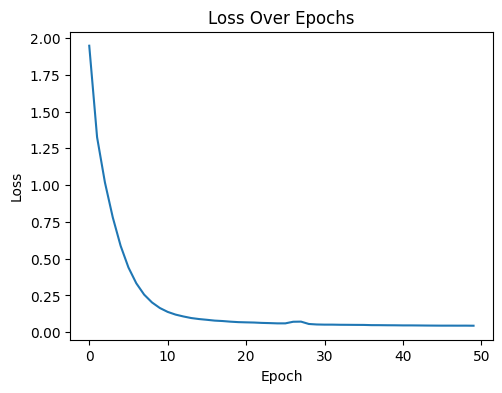

In [ ]:
import matplotlib.pyplot as plt
# Plot loss history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(loss_history)
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

#Test The Model
The evaluate() function serves to assess the model's performance on input sentences during the testing phase. Here's a breakdown of the steps it takes:

1. Initialize an attention plot to visualize where the model focuses its attention.
2. Preprocess the input sentence, which includes cleaning and preparing the text.
3. Convert the preprocessed sentence into a sequence of indices, and pad it to a fixed length.
4. Convert the sequence of indices into a tensor for model input.
5. Initialize an empty result string to store the translated sentence.
6. Initialize the hidden state for the encoder using zeros.
7. Pass the input through the encoder to get the encoded representation and updated hidden states.
8. Set up the initial hidden state for the decoder.
Initialize the decoder input with the '<start>' token.
9. Loop through the decoding process until the maximum target sequence length is reached.
10. Pass the decoder input, hidden states, and encoder output to the decoder to make predictions.
11. Record the attention weights for visualization.
12. Determine the predicted word ID with the maximum attention & Append the predicted word to the result. If the '<end>' token is predicted, terminate the loop.
13. Update the decoder input for the next iteration with the predicted word ID.
Return the translated result, the original input sentence, and the attention plot.
This function effectively utilizes the trained model to generate translations while monitoring the attention mechanism's behavior for each word.1.

In [ ]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(sentence):

  # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # Preprocess the sentence given
  sentence = preprocess_sentence(sentence)

  # Fetch the indices concerning the words in the sentence and pad the sequence
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  # Convert the inputs to tensors
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = hidden = [tf.zeros((1, units)), tf.zeros((1, units))]  # List with initial state and cell state

  enc_out, [enc_hidstate_h, enc_hidstate_c] = encoder(inputs, hidden)

  dec_hidden = [enc_hidstate_h, enc_hidstate_c]
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # Loop until the max_length is reached for the target lang (ENGLISH)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # Store the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Get the prediction with the maximum attention
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Append the token to the result
    result += targ_lang.index_word[predicted_id] + ' '

    # If <end> token is reached, return the result, input, and attention plot
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # The predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

#Plotting & Prediction

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
# Translate function (which internally calls the evaluate function)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input - As tu lu ce livre?

Expected output - Have you read this book?

Input: <start> as tu lu ce livre ? <end>
Predicted translation: did you read this book ? <end> 


<ipython-input-27-6f7d9f6c0cde>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-27-6f7d9f6c0cde>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


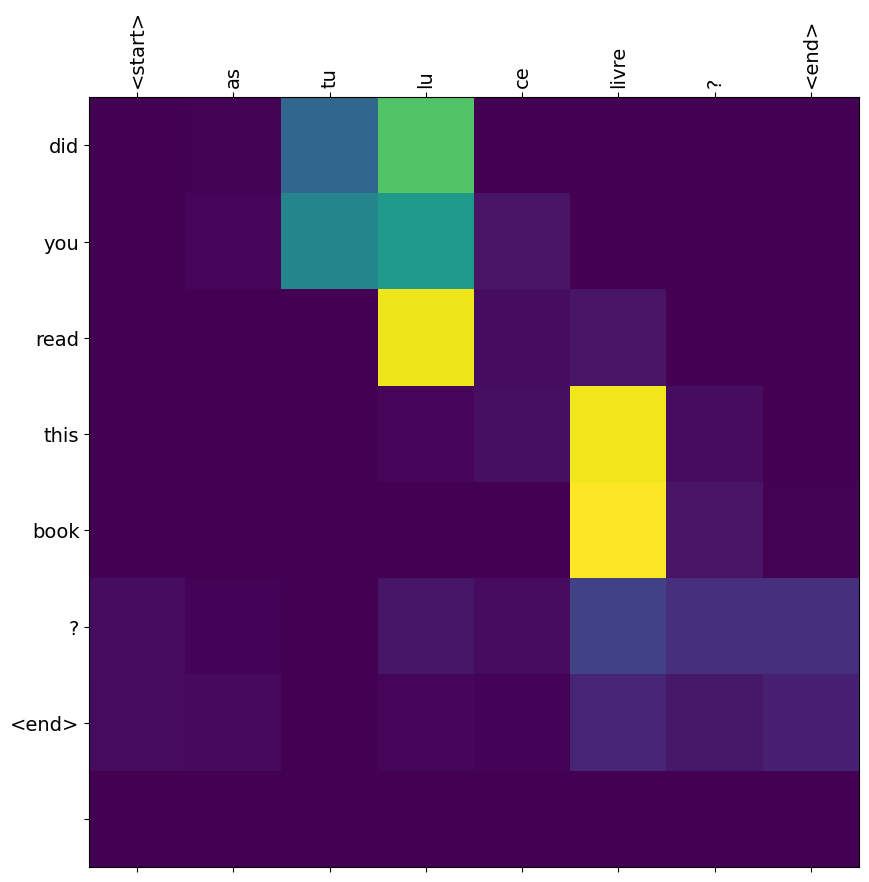

In [ ]:
translate(u"As tu lu ce livre?")